라이브러리 , 마운트
================================

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import keras
import keras.backend as K
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,shutil,cv2,glob

Mounted at /content/drive


기본 데이터 정의
============

In [2]:
SEED = 909

#배치사이즈
BATCH_SIZE = 32

#에폭의 수
NUM_OF_EPOCHS = 25

#UNet 깊이
UNet_level = 5

#Train,Valid 비율
validation_ratio=0.2

#백그라운드 포함 클래스 개수
num_class=5

initial_features = 32


IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

#데이터의 경로 설정
data_dir = '/content/drive/MyDrive/newstudy/fire_segmentation'
data_dir_train = os.path.join(data_dir, 'train')
data_dir_train_image = os.path.join(data_dir_train, 'images')
data_dir_train_mask = os.path.join(data_dir_train, 'masks')

data_dir_test = os.path.join(data_dir, 'test')
data_dir_test_image = os.path.join(data_dir_test, 'images')



In [3]:
#클래스 설정 

#클래스 자동지정 함수
def autoclass(num): 
  class_list=[[0,0,0]] #BG 컬러를 0으로 지정
  for i in range(num-1):
    class_list.append(list(np.random.choice(range(256), size=3)))
  return sorted(class_list)

#클래스별 색상
c = autoclass(num_class) #자동지정 list로 [R,G,B]형식으로 만들면 됨

c =[[0,0,0],
    [0,0,255],
    [127,127,127],
    [255,255,255],
    [255,0,0]]
    

#정보 출력
print(f'표현가능 클래스 개수 : {len(c)}')
print(f'클래스별 색상표 : {c}')
for i in range(1,len(c)):
  if c[i-1] == c[i]:
    print("중복 색상이 존재합니다.",i-1,i)


표현가능 클래스 개수 : 5
클래스별 색상표 : [[0, 0, 0], [0, 0, 255], [127, 127, 127], [255, 255, 255], [255, 0, 0]]


출력함수
==============================

In [4]:
def applycolor(img,color):
  #클래스 이미지에 색 적용
  h,w,c = img.shape

  for i in range(h):
    for j in range(w):
      for k in range(c):
        img[i,j,k] = color[img[i,j,k]][k]

  return img

def predict_img(img,color_output=True,get_last=False): 
  prediction = model.predict(np.expand_dims(img, axis=0)) #h,w,class

  if type(model.output) == list:
    num_of_output = len(model.output)
    x = prediction[num_of_output-1] if get_last else sum(prediction) / num_of_output
  else:
    x = prediction

  x = np.argmax(x[0], axis=-1) #해당픽셀의 채널 중에서 가장 큰 인덱스 값 가져옴 h,w
  x = np.expand_dims(x, axis=-1) #각 픽셀을단일로묶음 h,w,1
  x = x.astype(np.int32) #각 픽셀의 값을 int로 h,w,1
  x = np.concatenate([x, x, x], axis=2) #각픽셀 값을 3번 이어서 3채널로 만들어줌

  if color_output:
    x = applycolor(x,c)
  else :
    x = x * int(255/num_class-1) # 각 픽셀의 값을 곱해줌 h,w,1

  return x

def display(display_list, opt=0):
    plt.figure(figsize=(30,30))

    title = [['Input Image', 'True Mask', 'Mix Image(I/T)'],['Input Image', 'True Mask',  'Predicted Mask','Mix Image'],['Input Image' , 'Predicted Mask', 'Mix Image(I/P)']]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[opt][i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) #cmap='gray'
    plt.show()

def display_dataset(ds,num=1,predict=False,color_output=True,alpha=1.0,opt=0):
  i=0
  for x, y in ds:
    if i== num:
      break;
    display_list = []

    dx = x[0]*255
    dx = dx.numpy()

    #멀티 클래스의 경우
    
    dy = np.argmax(y[0], axis=-1)
    dy = np.expand_dims(dy, axis=-1) #각 픽셀을단일로묶음 h,w,1
    dy = dy.astype(np.int32) #각 픽셀의 값을 int로 h,w,1
    dy = np.concatenate([dy, dy, dy], axis=2)
    
    if color_output:
      dy = applycolor(dy,c)
    
    #단일 클래스의 경우
    #dy = y[0] * 255
    #dy = dy.numpy()

    display_list.append(dx)
    display_list.append(dy)

    if predict:
      p = predict_img(x[0],color_output)
      display_list.append(p)

    display_list.append(cv2.addWeighted(display_list[0].astype(np.int32), 1, display_list[predict+1], 0.5,0))

    display(display_list,opt)
    i+=1
  
def display_test(x,num=1,color_output=True,alpha=1.0,opt=2): #input만 있을 경우
  i = 0
  for x in x: #tqdm은 진행률 표시
    if i == num: 
      break
    display_list = []

    name = x.split('/')[-1] #filename 추출

    x = read_image(x)
    dx = x * 255

    p = predict_img(x,color_output)

    display_list.append(dx)
    display_list.append(p)

    display_list.append(cv2.addWeighted(display_list[0].astype(np.int32), 1, p, alpha,0))
    
    display(display_list,opt)
    i += 1

#model 학습 정보 표시,저장
def display_history(history, dir, num,save_pic=True,save_csv=True,save_best_infor=True):
  t = ['Accuracy','Loss']
  k = ['accuracy','loss']
  p = ['lower','upper']


  if type(model.output) != list : num_of_output = 1
  else: num_of_output = len(model.output)

  plt.figure(figsize=(24,3*num_of_output))

  for i in range(num_of_output):

    if type(model.output) != list : name = ''
    else: name = model.output_names[i]+'_'

    for j in range(4):
      plt.subplot(num_of_output,4,i*4+j+1)
      if j%2==0 :
        plt.plot(history[f'{name}{k[j//2]}'], 'g-', label= k[j//2])
        if i==0:
          plt.title(t[j//2])
      else :
        plt.plot(history[f'val_{name}{k[j//2]}'], 'g-', label= 'val_'+k[j//2])
        if i==0:
          plt.title('Val_'+t[j//2])
      if j==0:
        plt.ylabel(f'Output[{i}]')
      elif i== num_of_output-1 :
        plt.xlabel('Epoch')
      plt.legend(loc= p[j//2]+' right')
      plt.grid(True, axis='both',alpha=0.5)

  if (save_pic) : 
    plt.savefig(f'{dir}/Graph{num}.png')

  if (save_csv):
    hist_df = pd.DataFrame(history) 
    with open(f'{dir}/History{num}.csv', mode='w') as f:
      hist_df.to_csv(f)

  if (save_best_infor):
    idx = np.argmin(history['val_loss'])
    result = [['Epoch'],[idx+1]]
    start_idx = 1-(type(history) == dict)
    for i in range(start_idx,len(history.keys())):
      key = list(history.keys())[i]
      result[0].append(key)
      result[1].append(history[key][idx])
    hist_df = pd.DataFrame(result) 
    with open(f'{dir}/Best{num}.Infor.csv', mode='w') as f:
      hist_df.to_csv(f)
      
  plt.show()

데이터 전처리
====================

In [5]:

def read_image(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  x = cv2.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT))
  x = x / 255.0
  x = x.astype(np.float32)
  return x

def read_mask(x):
  x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (IMAGE_WIDTH, IMAGE_HEIGHT)) 
  x = x.astype(np.int32)
  return x

def tf_dataset(x, y, batch_size=1):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.map(preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

def preprocess(x, y):
  def f(x, y):
      x = x.decode()
      y = y.decode()
      image = read_image(x)
      mask = read_mask(y)

      return image, mask

  image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
  mask = tf.one_hot(mask, num_class, dtype=tf.int32)
  image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 3])
  mask.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, num_class])

  return image, mask

train_x = sorted(glob.glob(os.path.join(data_dir_train_image, '*')))
train_y = sorted(glob.glob(os.path.join(data_dir_train_mask, '*')))

train_x, valid_x = train_test_split(train_x, test_size=validation_ratio, random_state=SEED)
train_y, valid_y = train_test_split(train_y, test_size=validation_ratio, random_state=SEED)

test_x = sorted(glob.glob(os.path.join(data_dir_test_image,'*')))

print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE)

Dataset: Train: 7682 - Valid: 1921 - Test: 914


In [6]:
NUM_TRAIN = len(train_x)

NUM_VALID = len(valid_x)

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE
EPOCH_STEP_VALID = NUM_VALID // BATCH_SIZE

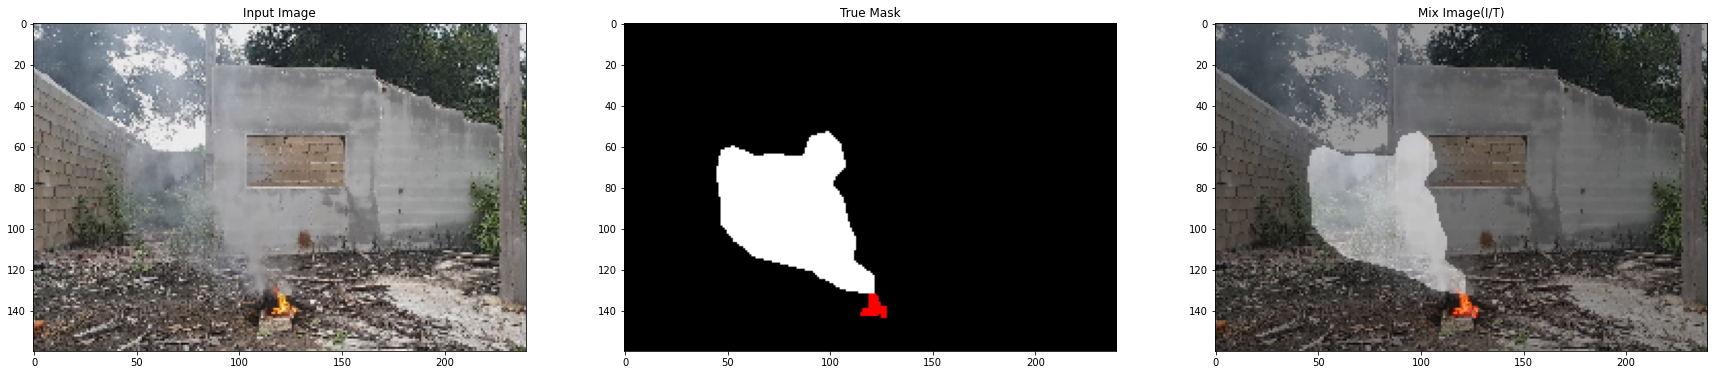

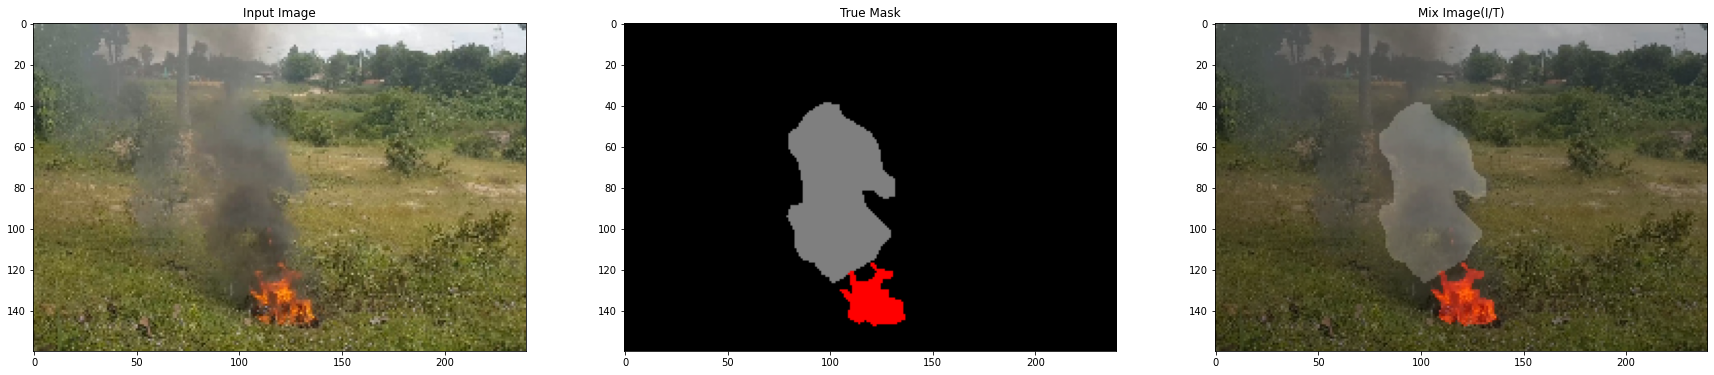

In [7]:
display_dataset(train_dataset,num=2,predict=False,color_output=True,alpha=0.5)

U-Net
====================

In [ ]:
def conv(input,features,kernel_size=3,strides = 1,padding='same',is_relu=True,is_bn=True):
  x = keras.layers.Conv2D(features,kernel_size,strides,padding,kernel_initializer='he_normal')(input)
  if is_bn:
    x = keras.layers.BatchNormalization()(x)

  if is_relu:
    x = keras.activations.relu(x)

  return x

def unet(n_levels, initial_features=initial_features, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=3, out_channels=num_class):
  inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
  x = inputs
  
  #인코더부분
  skips = []
  for level in range(n_levels):
    if level != 0 :
      x = keras.layers.MaxPool2D(pooling_size)(x)
    for _ in range(n_blocks):
      x = conv(x,initial_features * 2 ** level,3,1,'same')
    skips.append(x)

  # 디코더 부분
  for level in reversed(range(n_levels-1)):
    x = keras.layers.UpSampling2D(pooling_size, interpolation='bilinear')(x) 
    x = conv(x,initial_features * 2 ** level,2,1,'same')

    x = keras.layers.Concatenate()([x, skips[level]])
    for _ in range(n_blocks):
      x = conv(x,initial_features * 2 ** level,3,1,'same')
          
  # 결과
  x = keras.layers.Conv2D(out_channels, kernel_size=1, padding='same')(x)

  if out_channels == 1:
    x = keras.activations.sigmoid(x)
  else:
    x = keras.activations.softmax(x)
  
  return keras.Model(inputs=[inputs], outputs=x, name=f'UNET-L{n_levels}-F{initial_features}')

model = unet(UNet_level)

모델 요약
=====================

In [ ]:
model.summary()

학습+예측 이미지
=========================

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.name,"모델이 컴파일 되었습니다.")
if (os.path.exists(f'{data_dir}/{model.name}.h5')):
  print('해당모델과 같은 이름의 모델이 학습되고 있습니다.')
if (os.path.exists(f'/content/drive/MyDrive/data/model/{model.name}-H{IMAGE_HEIGHT}-W{IMAGE_WIDTH}-{BATCH_SIZE}')):
  print('해당모델과 같은 이름의 모델이 이전에 학습된 적이 있습니다.')
print('Model Outputs :' , model.output_names)

In [ ]:
#학습부분
print(f'Train Data:{NUM_TRAIN}')
print(f'Valid Data:{NUM_VALID}')
print(f'Epochs:{NUM_OF_EPOCHS}')
print(f'Batch Size:{BATCH_SIZE}')
print(f'U-NET Level:{UNet_level}')
print(f'Model Name:{model.name}')
print(f'Loss:{model.loss}')
print(f'Dataset Name:{data_dir.split("/")[-1]}')
print(f'I/O Image Size (H * W):{IMAGE_HEIGHT} * {IMAGE_WIDTH}')

cp_dir = f'{data_dir}/{model.name}.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath=cp_dir, 
                                        save_best_only=True,
                                        verbose=1
                                        )

history = model.fit(train_dataset,
                    steps_per_epoch=EPOCH_STEP_TRAIN,
                    validation_data=valid_dataset,
                    validation_steps=EPOCH_STEP_VALID,
                    epochs=NUM_OF_EPOCHS,
                    callbacks=[mc]
                    )

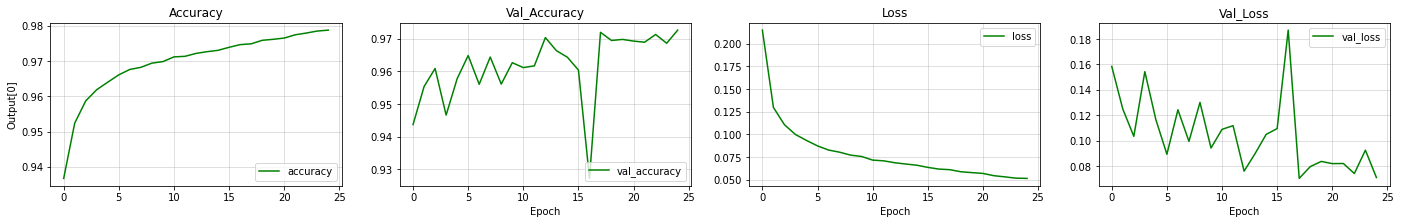

In [ ]:
save_dir = f'{data_dir}/model/{model.name}-H{IMAGE_HEIGHT}-W{IMAGE_WIDTH}-{BATCH_SIZE}'

if os.path.exists(save_dir) == False:
  os.makedirs(save_dir)

new_model_num = 1
while (os.path.exists(f'{save_dir}/Model{new_model_num}.h5')):
  new_model_num += 1

model.save(f'{save_dir}/Model{new_model_num}.h5')
if os.path.exists(cp_dir):
  shutil.move(cp_dir,f'{save_dir}/Best{new_model_num}.h5')
display_history(history.history,save_dir,new_model_num,True,True,True)

In [ ]:
display_test(test_x,150,True,0.5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
display_dataset(train_dataset,num=100,predict=True,color_output=True,alpha=0.5,opt=1)

In [ ]:
data_dir_test2 = os.path.join(data_dir, 'test2')

test2_x = sorted(glob.glob(os.path.join(data_dir_test2,'*')))

display_test(test2_x,len(test2_x),True,0.5)


모델 불러오기
===============

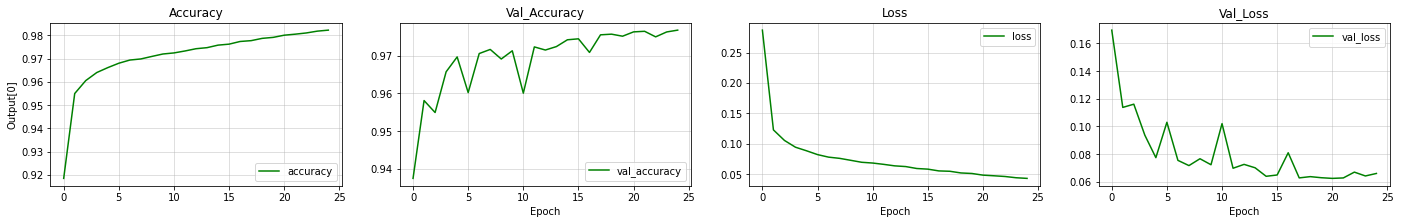

In [19]:
# 이전에 컴파일 한 모델 불러오기
load_dir = f'{data_dir}/model/UNET-L5-F16-H160-W240-8'
model_num = 1

sel_best = False
model_name = ''

if sel_best == True: 
  model_name = 'Best' 
else :
  model_name = 'Model'


if os.path.exists(f'{load_dir}/{model_name}{model_num}.h5'):
  model = tf.keras.models.load_model(f'{load_dir}/{model_name}{model_num}.h5')
else :
  print('모델이 없습니다.')

if os.path.exists(f'{load_dir}/History{model_num}.csv'):
  history = pd.read_csv(f'{load_dir}/History{model_num}.csv')
  display_history(history,load_dir,model_num,True,False,True) 
else :
  print("학습과정에 대한 정보가 없습니다.")